# Cleaning, pre-processing, exploring and clustering (into groups) a customer dataset.

In [257]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder

In [258]:
data = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")
data.shape[0]

8068

### The data provided contains both train and test set, but as we will not be doing regression or classification we will combine these two datasets.

In [259]:
data = pd.concat([data, data_test], axis=0)
data.shape[0]

10695

In [260]:
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


### Lets drop the first and last column as they are no use for us.

In [261]:
data.drop(["ID", "Segmentation"], axis=1, inplace=True)

## Encode Categorical Data

### Encode categorical data before cleaning as we will utilize iterative imputer for missing values, which requires that all columns contain numeric values only.

In [262]:
# Categories with no ordering
cat_no_order = ["Gender", "Ever_Married", "Graduated", "Profession"]
oh = OneHotEncoder(handle_unknown="ignore")
for col in cat_no_order:
    data[col] = pd.DataFrame(oh.fit_transform(data[[col]]).toarray())

In [263]:
# Unique values in categorical columns which have ordering
cat_order = ["Spending_Score", "Var_1"]
for col in cat_order:
    print(data[col].unique())

# Use pandas mapping to map these values ordinally. Normally use OrdinalEncoder but just use mapping as there aren't too many categories.
data[cat_order[0]] = data[cat_order[0]].map({"Low" : 0, "Average" : 1, "High" : 2})
data[cat_order[1]] = data[cat_order[1]].map({"Cat_1" : 0, "Cat_2" : 1, "Cat_3" : 2, "Cat_4" : 3, "Cat_5" : 4, "Cat_6" : 5, "Cat_7" : 6})

['Low' 'Average' 'High']
['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5']


In [264]:
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,0.0,1.0,22,1.0,0.0,1.0,0,4.0,3.0
1,1.0,0.0,38,0.0,0.0,NaN,1,3.0,3.0
2,1.0,0.0,67,0.0,0.0,1.0,0,1.0,5.0
3,0.0,0.0,67,0.0,0.0,0.0,2,2.0,5.0
4,1.0,0.0,40,0.0,0.0,NaN,2,6.0,5.0


## Cleaning

In [265]:
def get_missing():
    return data.isnull().mean() * 100

In [266]:
data_null_mean = get_missing()
data_null_mean.round(2)

Gender              0.00
Ever_Married        0.00
Age                 0.00
Graduated           0.00
Profession          0.00
Work_Experience    10.27
Spending_Score      0.00
Family_Size         4.19
Var_1               1.01
dtype: float64

<AxesSubplot:>

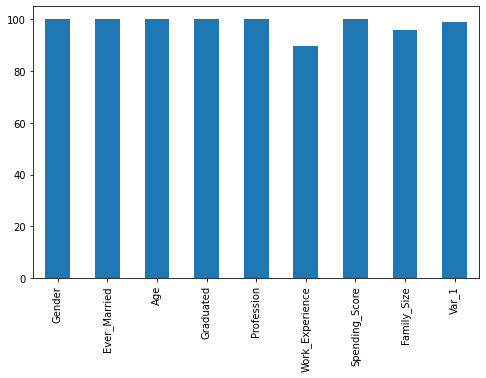

In [267]:
fig, ax = plt.subplots(figsize=(8, 5))
(100 - data_null_mean).abs().plot.bar(ax=ax)

### As there is no extreme amount of missing values, let us impute all the columns using the sophisticated IterativeImputer.

In [268]:
def get_missing_cols(): # Separate columns with missing values into numeric and categorical lists.
    missing_num = []
    missing_cat = []
    for col in list(data.isnull().columns):
        if data[col].dtypes == "object":
            missing_cat.append(col)
        else:
            missing_num.append(col)
    return (missing_num, missing_cat)

In [269]:
num, cat = get_missing_cols()
missing_cols = (num + cat)
imputer = IterativeImputer(random_state=0)
data[missing_cols] = imputer.fit_transform(data[missing_cols])

In [270]:
get_missing()

Gender             0.0
Ever_Married       0.0
Age                0.0
Graduated          0.0
Profession         0.0
Work_Experience    0.0
Spending_Score     0.0
Family_Size        0.0
Var_1              0.0
dtype: float64

### Cleaning column names. The columns headers are not "python friendly" and I can spot at least one that isn't very descriptive. Lets change that.

In [271]:
def clean_col_name(name):
    return name.strip().lower().replace(" ", "_")

In [272]:
data.rename(columns={"Var_1" : "customer_category"}, inplace=True) # Rename Var_1 to "(anomymous) customer category"
data.rename(columns=clean_col_name, inplace=True)
data.head()

,gender,ever_married,age,graduated,profession,work_experience,spending_score,family_size,customer_category
0,0.0,1.0,22.0,1.0,0.0,1.000000,0.0,4.0,3.0
1,1.0,0.0,38.0,0.0,0.0,3.055276,1.0,3.0,3.0
2,1.0,0.0,67.0,0.0,0.0,1.000000,0.0,1.0,5.0
3,0.0,0.0,67.0,0.0,0.0,0.000000,2.0,2.0,5.0
4,1.0,0.0,40.0,0.0,0.0,2.451970,2.0,6.0,5.0
